In [20]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_2dm_34 as fresnel
import apra_pop_models.fraunhofer_2dm_34 as fraunhofer
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
import apra_pop_models.pwp as pwp

import lina

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


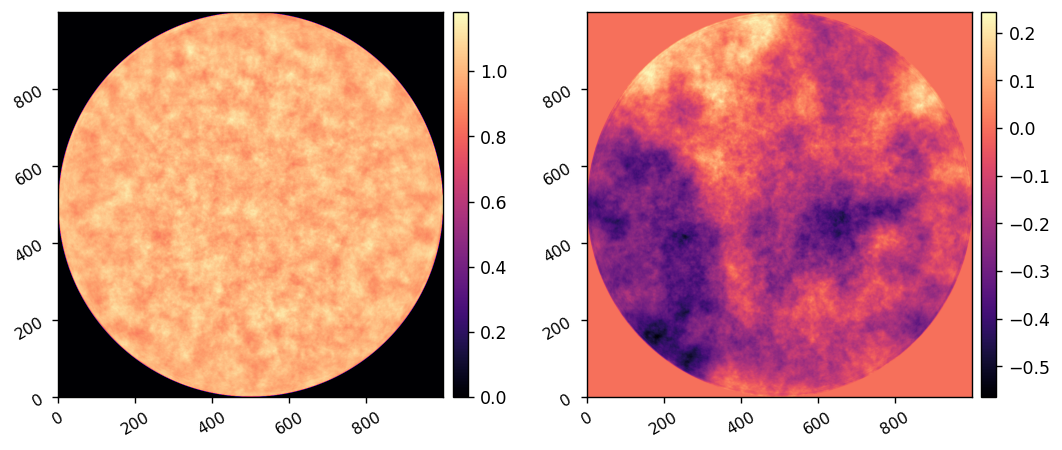

In [4]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

WFE = I.calc_pupil()
imshow2(xp.abs(WFE), xp.angle(WFE))

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


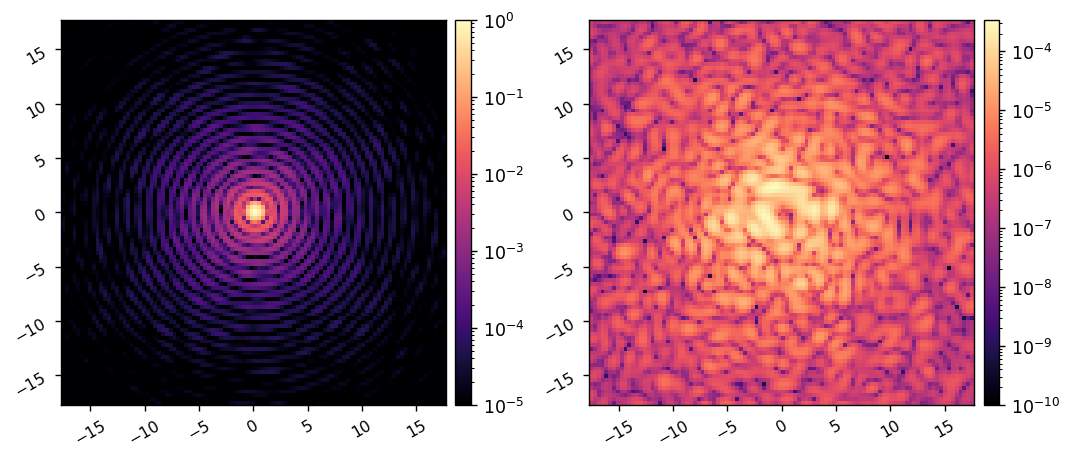

In [5]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)

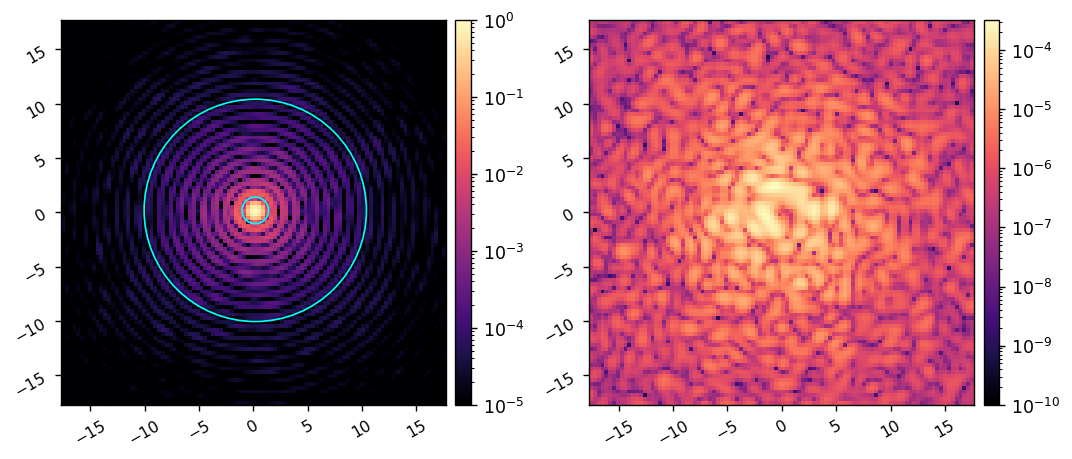

In [44]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.WFE = WFE
# M.WFE = xp.rot90(xp.rot90(WFE))

M.flip_dm = True
M.flip_lyot = True
# M.det_rotation = 180

acts = np.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, use_vortex=False) )**2
M.Imax_ref = xp.max(model_psf)
model_psf /= M.Imax_ref
model_coro_im = xp.abs( M.forward(acts, use_vortex=True) )**2

psf_center = (M.psf_pixelscale_lamD/2, M.psf_pixelscale_lamD/2)
imshow2(model_psf, model_coro_im, lognorm=True, vmin1=1e-5, vmin2=1e-10, 
        pxscl=M.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='cyan'), Circle(psf_center, 10.22, fill=False, color='cyan')])




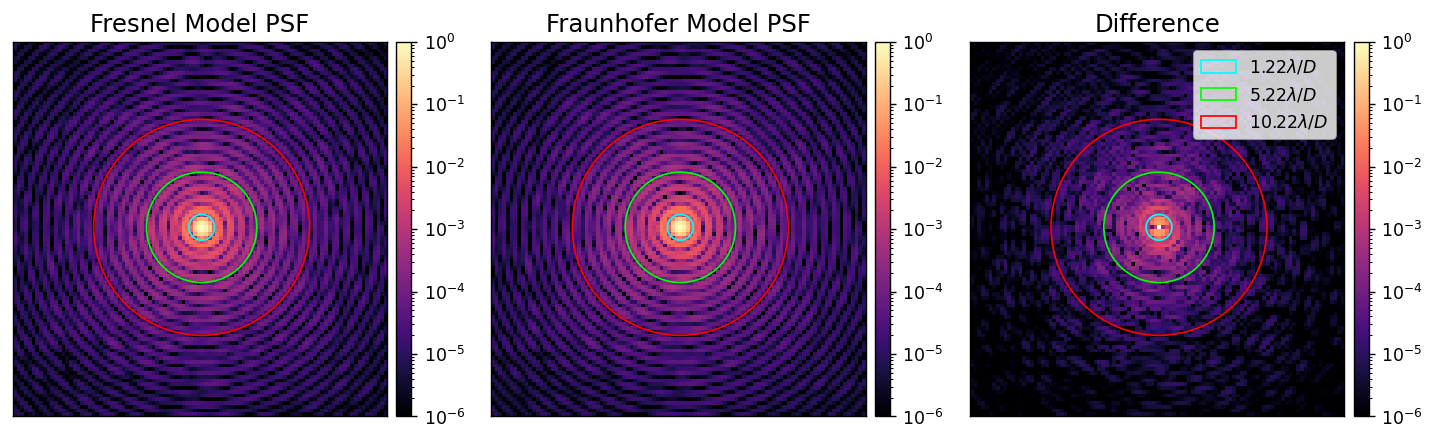

In [13]:
pxscl = I.psf_pixelscale_lamD
diff = ref_psf - model_psf
fig,ax = imshow3(ref_psf, model_psf, xp.abs(diff), 
                 
                lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-6, 
                lognorm3=True, vmin3=1e-6, vmax3=1,
                pxscl=I.psf_pixelscale_lamD, 
                grid=True,
                patches1=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches2=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches3=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', label='1.22$\lambda/D$', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime', label='5.22$\lambda/D$'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red', label='10.22$\lambda/D$')],
                wspace=0.2,
                display_fig=False, return_fig=True,)
fontsize = 14
ax[0].set_title('Fresnel Model PSF', fontsize=fontsize)
ax[1].set_title('Fraunhofer Model PSF', fontsize=fontsize)
ax[2].set_title('Difference',  fontsize=fontsize)
fontsize = 10
ax[2].legend(loc='upper right', fontsize=fontsize)
ticks = np.linspace(-15,15,7)
ticks = []
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[1].set_xticks(ticks)
ax[1].set_yticks(ticks)
ax[2].set_xticks(ticks)
ax[2].set_yticks(ticks)
display(fig)

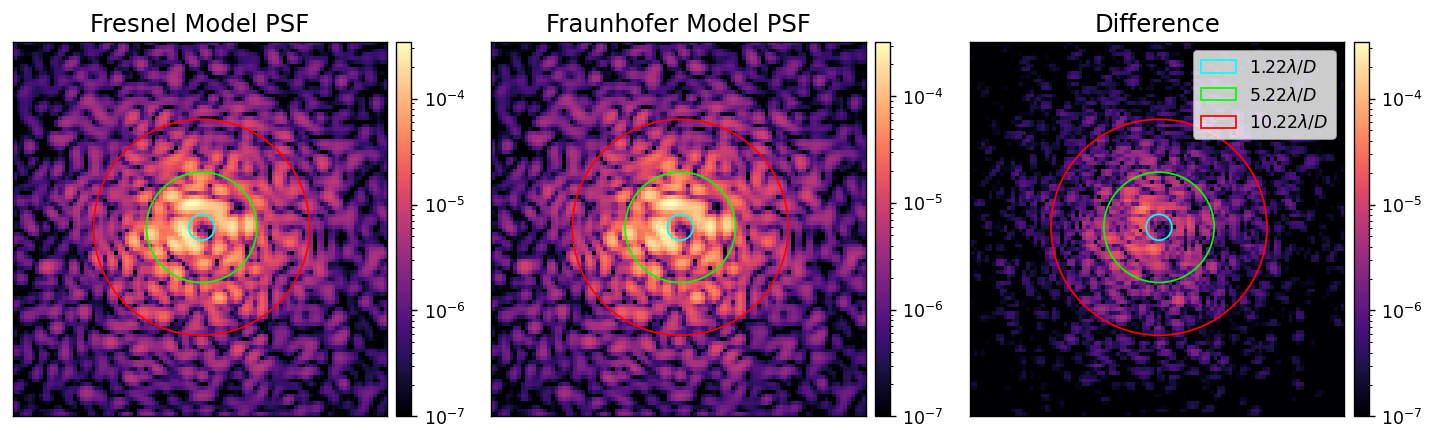

In [18]:

diff = ref_coro_im - model_coro_im
fig,ax = imshow3(ref_coro_im, model_coro_im, xp.abs(diff), 
                'Fresnel Model Coronagraphic Image', 'Fraunhofer Model Coronagraphic Image', 'Difference', 
                lognorm1=True, lognorm2=True, vmin1=1e-7, vmin2=1e-7, 
                lognorm3=True, vmin3=1e-7, vmax3=xp.max(ref_coro_im),
                pxscl=I.psf_pixelscale_lamD, 
                grid=True,
                patches1=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches2=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches3=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', label='1.22$\lambda/D$'),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime', label='5.22$\lambda/D$'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red', label='10.22$\lambda/D$')],
                wspace=0.2,
                display_fig=False, return_fig=True,)
fontsize = 14
ax[0].set_title('Fresnel Model PSF', fontsize=fontsize)
ax[1].set_title('Fraunhofer Model PSF', fontsize=fontsize)
ax[2].set_title('Difference',  fontsize=fontsize)
fontsize = 10
ax[2].legend(loc='upper right', fontsize=fontsize)
ticks = np.linspace(-15,15,7)
ticks = []
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[1].set_xticks(ticks)
ax[1].set_yticks(ticks)
ax[2].set_xticks(ticks)
ax[2].set_yticks(ticks)
display(fig)

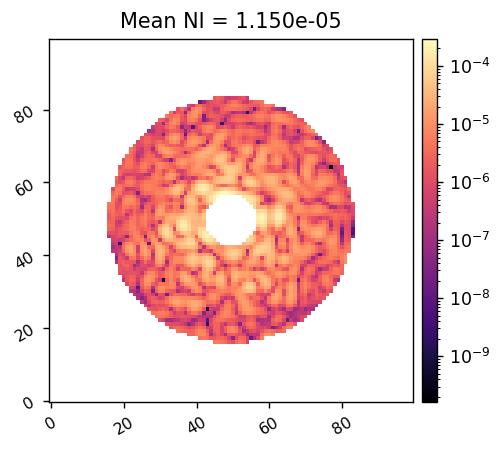

In [21]:
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)

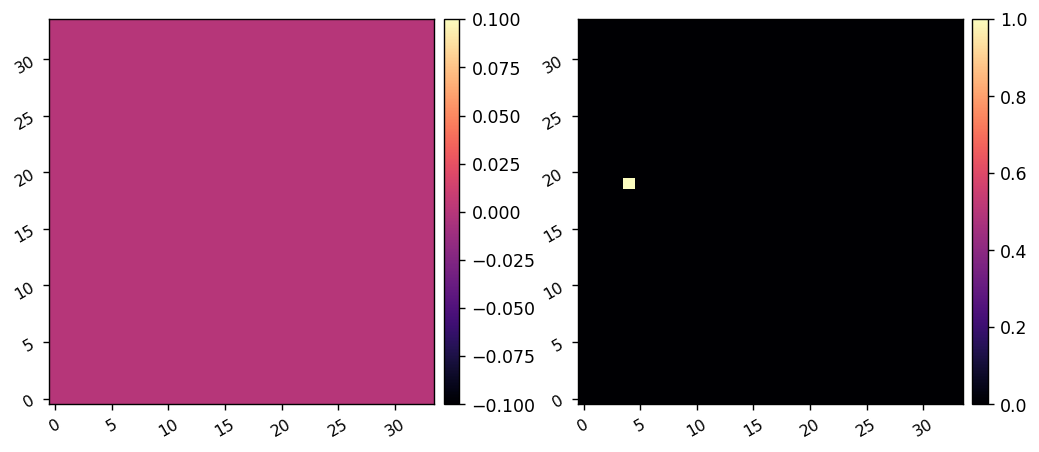

In [42]:
reload(efc_utils)
poke_modes = efc_utils.create_all_poke_modes(M.dm_mask, ndms=2)

imshow2(poke_modes[1500][:M.Nact**2].reshape(M.Nact, M.Nact), poke_modes[1500][M.Nact**2:].reshape(M.Nact, M.Nact))

Calculating Jacobian: 
	Calculated response for mode 1904/1904. Elapsed time=200.886 sec.
Jacobian built in 200.886 sec


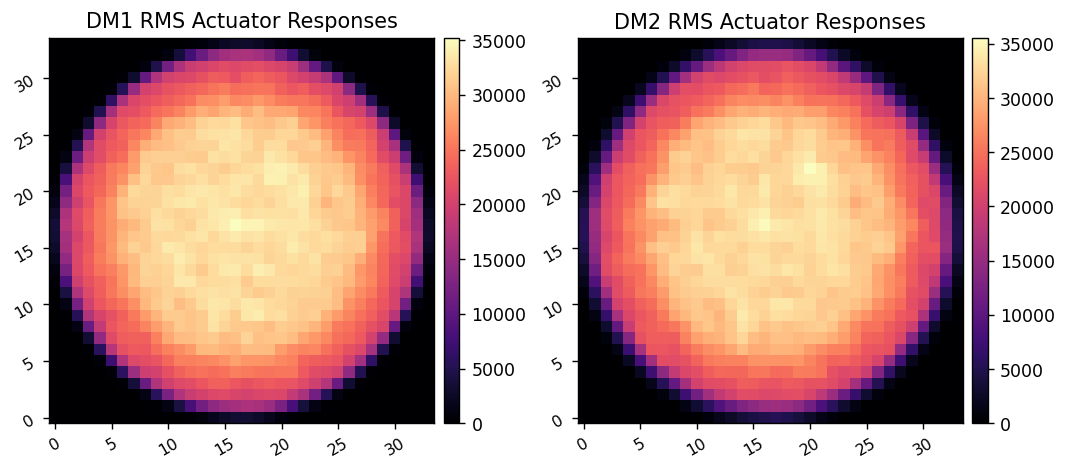

In [46]:
reload(efc)
M.zero_dms()
jac = efc.build_jacobian(M, 1e-9, poke_modes, control_mask, plot_responses=True,)

In [88]:
utils.save_fits('../jacobians/jac.fits', jac)

Saved data to:  ../jacobians/jac.fits


# Run EFC without PWP

In [77]:
I.zero_dms()
all_ims = []
all_efs = []
all_commands = []


Beginning closed-loop EFC simulation.
	Running iteration 13/15.
	Mean NI of this iteration: 8.002e-11


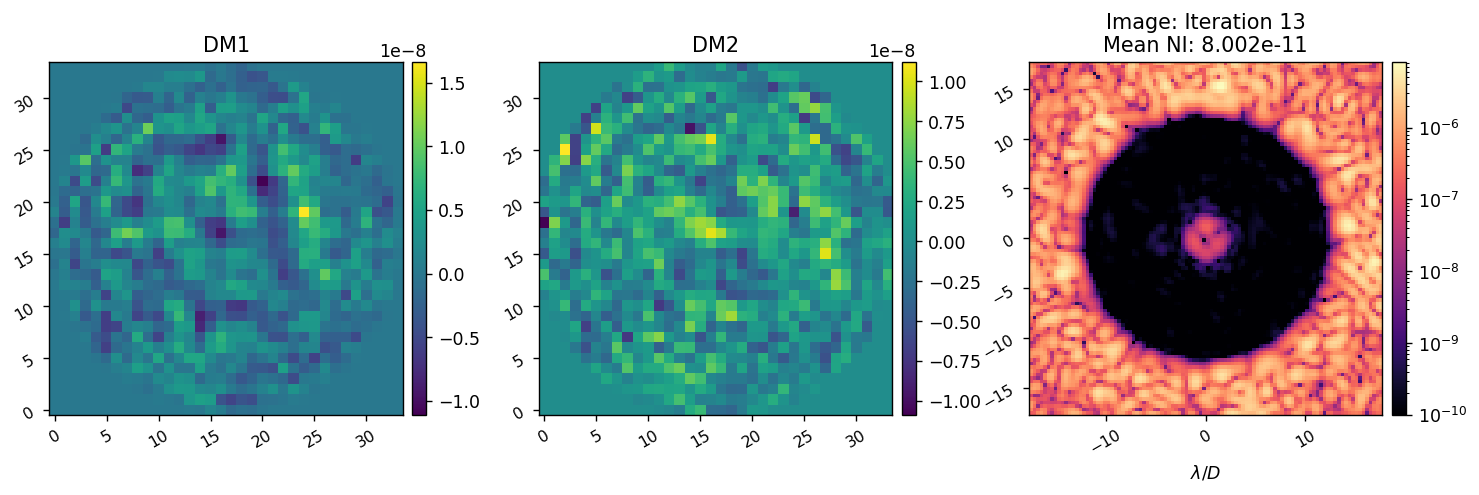

	Running iteration 14/15.
	Mean NI of this iteration: 3.697e-11


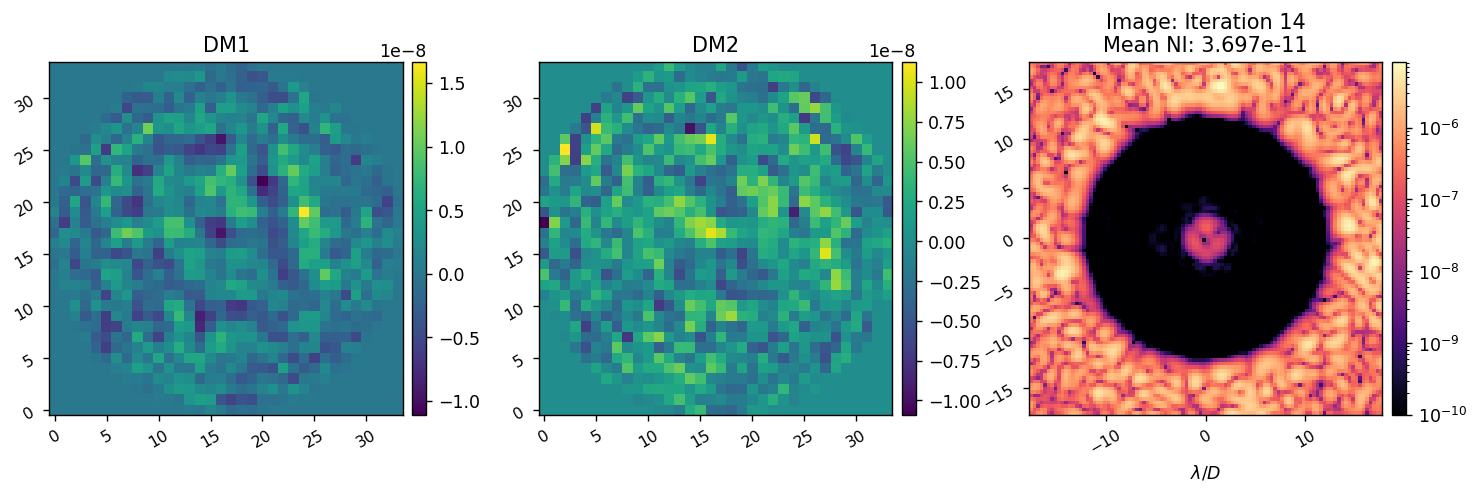

	Running iteration 15/15.
	Mean NI of this iteration: 2.066e-11


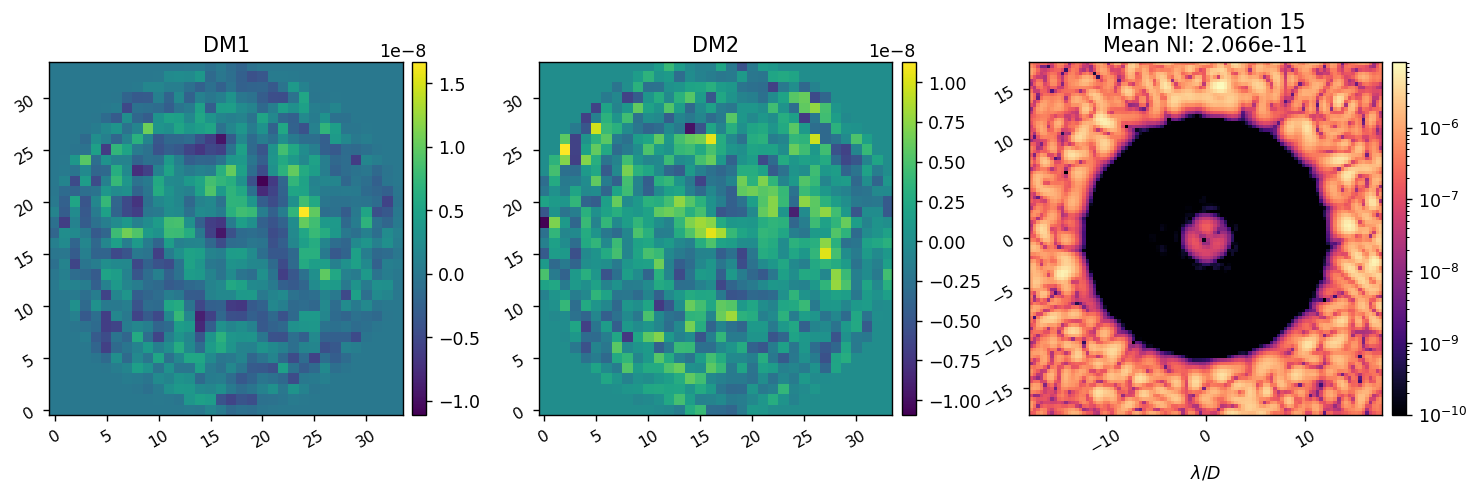

In [82]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

all_ims, all_efs, all_commands = efc.run(I, 
                                        jac, 
                                        reg_fun, reg_conds,
                                        control_mask, 
                                        # est_fun=pwp_fun, est_params=pwp_params,
                                        gain=0.5, 
                                        leakage=0.0,
                                        iterations=3, 
                                        plot_all=True, 
                                        all_ims=all_ims,
                                        all_efs=all_efs,
                                        all_commands=all_commands,
                                        )

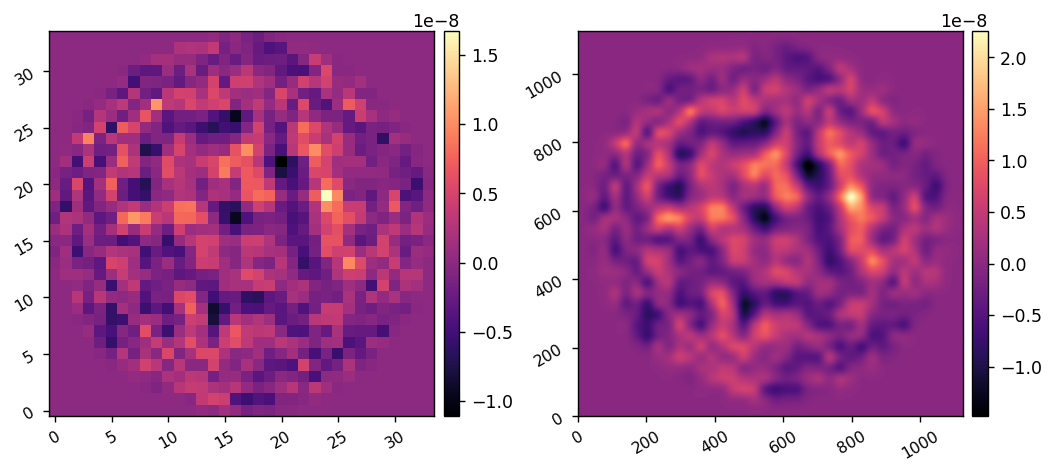

In [86]:
imshow2(I.get_dm1(), I.DM1.get_surface())

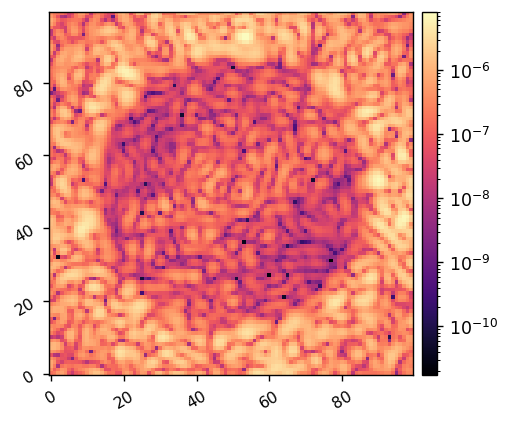

In [83]:
M.set_dm1(I.get_dm1())
M.set_dm2(I.get_dm2())

model_im = M.snap()
imshow1(model_im, lognorm=True)